Benchmarks for model order reduction in finance
============

### Benchmark Case 2.2: Adaptive Greedy Sampling

The main task of this research is to implement a parametric model order reduction
approach for financial risk analysis. Second benchmark case is to verify 
the implemented MOR algorithm. We use a finite difference method for 
simulating the convection-diffusion-reaction PDE. 
The projection-based MOR approach has been implemented, and 
the reduced-order basis is obtained using the proper orthogonal decomposition 
approach with the classical and adaptive greedy sampling methods.

This benchmark case runs the adaptive greedy sampling approach

Inputs:
- Parameter space (a, b, sigma):
  - a: Deterministic drift
  - b: Mean reversion speed
  - sigma: volatility
- Maximum number of greedy iterations: Imax
- maximal number of parameter groups to initiate algorithm: c
- number of adaptive candidates: ck
- tolerance: max_tol
    
Outputs:
 - Reduced Basis: Q_d
 - Relative error between FOM and ROM: RelativeError
 - Speed up factor: SpeedUpFactor


### Installation

Install the input/output and statistics Ocatave package for reading/writting .xlsx files and manage random samples

In [1]:
pkg install -forge io statistics
pkg load io statistics


The gnuplot graphics toolkit is not actively maintained and has a number
of limitations that are ulikely to be fixed.  Communication with gnuplot
uses a one-directional pipe and limited information is passed back to the
Octave interpreter so most changes made interactively in the plot window
will not be reflected in the graphics properties managed by Octave.  For
example, if the plot window is closed with a mouse click, Octave will not
be notified and will not update it's internal list of open figure windows.
We recommend using the qt toolkit instead.

    install at line 36 column 5
    pkg at line 568 column 9

For information about changes from previous versions of the statistics package, run 'news statistics'.


### Computations

Model parameters

In [2]:
M = 800;                                        % grid points along spatial direction
T = 3660;                                       % Time to maturity in days (10 yrs)
lower = -0.08;                                  % Lower bound of r given by eq. 5.33 book by Andreas
upper = 0.08;
% Model Parameters
sigma = 0.006;
a1 = xlsread('../benchmarks/DD_1FHWModel_10000.xlsx');
a = a1(:,:);
b = 0.015;
% time step
dt =20/360;
% Maturity of a floater
MT = 10;
% Number of snapshots
NS = 10;

Face value floor rate and cap rate with cap frequency 

In [3]:
FV =1;
FloorR = 0.005;
CapR = 0.025;
CopFre = 4; % CopFre = 4 or 2.
Maturity = 'Maturity10'; % Maturity = Maturity10, Maturity5.

Reference interest rate

In [4]:
SwapCurves = xlsread('../benchmarks/ReferenceRate_1906.xlsx'); %% Obtained by runing SwapCurveSimulation.nb file
FR1 = SwapCurves(:,[4:13]);
RRFR = repelem(FR1./CopFre,1,CopFre);

### Adaptive Greedy POD

Initiate AG algorithm with first parameter group and adaptive Greedy iterations loop

In [9]:
    %% Initiate AG algorithm with first parameter group.
    % Here the first parameter group with a(1:1,:) and b, sigma is shown.
    [BOND,SnapShot1,Elapsed1] = FullModel(RRFR(1,:),a(1,:),b,sigma,M,lower,...
        upper,dt,MT,FV,FloorR,CapR,CopFre,NS,Maturity);

    % Compute SVD and obtain Q
    [U,~,V] = svd(SnapShot1{1},'econ');
    Q_I = U;
    
    % Set max tolerance and number of max iterations
    IMax = 10;                       % Maximum iterations for AGreedyPOD
    max_tol = 1*10^-8;              % Maximum relative error
    
    %%
    tic;
    % Adaptive Greedy iterations start
    
    for i = 2:IMax
        
        c0= 20;
        % Select the random parameter groups.
        RandSel = randsample(length(a),c0);
        NpSel = a(RandSel,:); %Randomly select 20 parameter groups (here NpSel)
        RefR = RRFR(RandSel,:);

        % Solve the ROMs using $Q_I$ for randomly selected 20 parameter groups 
    
        for jj = 1:size(NpSel,1)
            [BONDr,resd] = ReducedModel(RefR(jj,:),NpSel(jj,:),b,sigma,M,...
                lower,upper,dt,MT,FV,FloorR,CapR,CopFre,Q_I);
            Error(1,jj) = resd;
        end
    
        jjj=1;
        NpSel2 = NpSel;
        Error2 = Error;
        SMts = tic;
        
        % Surrogate Model Loop
        
        while size(NpSel2) < 40
    
            % Surrogate Model (Principal compnent regression) based on 
            % residuals obtained (Error)   
    
            %B = PCRSM(NpSel2,Error2',3); % Coefficients of regression model (with intercept in MATLAB)
            %[~,~,~,~,B,~,~,~] = plsregress(NpSel2,Error2',3);% Coefficients of regression model (with intercept in MATLAB)
            %SM = [ones(size(a(:,1))) a]*B;
            [~,~,~,~,B,~] = plsregress(NpSel2,Error2',3);% Coefficients of regression model (without intercept in OCTAVE)
            SM = [ones(size(a(:,1))) a]*[mean(Error2')-mean(NpSel2)*B; B];

            % Search over the SM values and find first max 10 values and 
            % corresponding parameters  
            
%             % KNN model
%             K =1;
%             SM = KNN(a,NpSel2,Error2,K);
%         
%             [MAX_SM(x,:),MAX_SMid(x,:)] = maxk(SM,10);
            
            % while loop
            ck =10;
            % Parameter search
            [MAX_SM(jjj,:),MAX_SMid(jjj,:)] = maxk(abs(SM),ck); 
            NpSel2 = cat(1,NpSel,a(MAX_SMid',:));
            RefR2 = cat(1,RefR,RRFR(MAX_SMid',:));
    
            %filename = sprintf('NpSel2_%03d.xls', i);
            %xlswrite(filename,NpSel2);    
    
            % Solve the ROMs again for newly generated parameter set
            for ii = 1:size(NpSel2,1)
                [BONDr,resdd] = ReducedModel(RefR2(ii,:),NpSel2(ii,:),b,sigma,...
                    M,lower,upper,dt,MT,FV,FloorR,CapR,CopFre,Q_I);
                Error2(1,ii) = resdd;
            end

            % filename = sprintf('ErrData_%03d.xls', i);
            % xlswrite(filename,Error2);  
    
            jjj = jjj + 1;
        end

        % Find parameter group correpsonding to the maximum error from the
        % set of Error2
    
        avrg_error(1,(i-1)) = mean(Error2);
        [max_Error(1,(i-1)),max_idErr(1,(i-1))] = max(Error2(:));
    
        % Next Q and break for next iteration if convergence reach
        if i > 2 && RE_appx(1,i-1) < max_tol
            Q = Q_I;
            break
        end
        SMTime = toc(SMts);
        
        % Concatenate parameter groups
        paraGr = cat(1,a(1,:),NpSel2([max_idErr],:));
        RefRGr = cat(1,RRFR(1,:),RefR2([max_idErr],:));
    
        % Compute HDM and ROM (Using $Q_{Niter-1}$) for paramete1r 
        % $\rho_mx$ (here NpSel2(max_idErr(1,(Niter-1)),:))
    
        [BOND1] = FullModel(RefR2(max_idErr(1,(i-1)),:),NpSel2(max_idErr(1,(i-1)),:),...
            b,sigma,M,lower,upper,dt,MT,FV,FloorR,CapR,CopFre,NS,Maturity);
        
        [BONDr1,resd_b(1,i-1)] = ReducedModel(RefR2(max_idErr(1,(i-1)),:),...
            NpSel2(max_idErr(1,(i-1)),:),b,sigma,M,lower,upper,dt,MT,FV,FloorR,...
            CapR,CopFre,Q_I);
    
        % Compute relative error $RE$ between HDM and ROM for $\rho_mx$.
        % The name RE_b suggest that the error is calculate before updating
        % the ROB Q_Niter
    
        RE_b(1,i-1) = norm((BOND1{1} - BONDr1{1}),2)/norm(BOND1{1},2);
    
        % Construct snapshot matrix using 'ParaGr'
        [BOND,SnapShot_paraGr] = FullModel(RefRGr,paraGr,b,sigma,M,lower,upper,...
            dt,MT,FV,FloorR,CapR,CopFre,NS,Maturity);
        
        % Snapshot matrix
        SnapShots = cat(2,SnapShot_paraGr{:});
    
        % Perform SVD (I have used Random SVD for fast computation)
        RankS(1,i-1) = rank(SnapShots); 
        [U1,S1,V1] = RandSVD(SnapShots,RankS(1,i-1));
    
        % Update the ROB: Q_Niter = U1
        Q_I = U1;
    
        % Solve the ROM for parameter $\rho_mx$ again using new Q_Niter 
        % and compute the relative error RE_a between HDM and ROM.\
        
        % Here RE_a represents the error after updating ROB
    
        [BONDr2,resd_a(1,i-1)] = ReducedModel(RefR2(max_idErr(1,(i-1)),:),...
            NpSel2(max_idErr(1,(i-1)),:),b,sigma,M,lower,upper,dt,MT,FV,FloorR,...
            CapR,CopFre,Q_I);
        RE_a(1,i-1) = norm((BOND1{1} - BONDr2{1}),2)/norm(BOND1{1},2);

        % Construct log-log model for relative error using RE_a and RE_b
        % based on residual errors 
    
        RE_U = cat(2,RE_b,RE_a);
        resd_U = cat(2,resd_b,resd_a);
        
%         Ep = cat(RE_u, resd_U);
        E_mdl = polyfit(log(resd_U),log(RE_U),1);
        RE_appx(1,i) = exp(E_mdl(:,2)).*(max_Error(1,i-1))^(E_mdl(:,1));
    end
    toc

Elapsed time is 4272.2 seconds.


Selection of the reduced dimension

In [15]:
Eg = diag(S1)./sum(diag(S1));
% 
for ii = 1:length(Eg)
    SumEg = sum(Eg(1:ii,1))*100;
    if SumEg > 99.99
        d = ii;
        break
    end
end

% Reduced order basis
Q_d = Q_I(:,1:d);

Select random parameter group for testing

In [16]:
yy = randi([1 10000],1,1);

tStart = tic; 
[BOND1] = FullModel(RRFR(yy,:),a(yy,:),b,sigma,M,lower,upper,dt,MT,FV,...
    FloorR,CapR,CopFre,NS,Maturity);
tEnd = toc(tStart)*10;
tFM = tEnd;
% % % % % % % % TotalTF = sum(Elapsed11);

tStartRM = tic; 
[BOND1r] = ReducedModel(RRFR(yy,:),a(yy,:),b,sigma,M,lower,upper,dt,MT,FV,...
    FloorR,CapR,CopFre,Q_d);
tEndRM = toc(tStartRM);
tRM = tEndRM*0.1;

Compute relative error and plot outputs

ans = -86.577
ans = -64.674
ans = -49.336
ans = -32.633
ans = -15.077
ans = -96.794


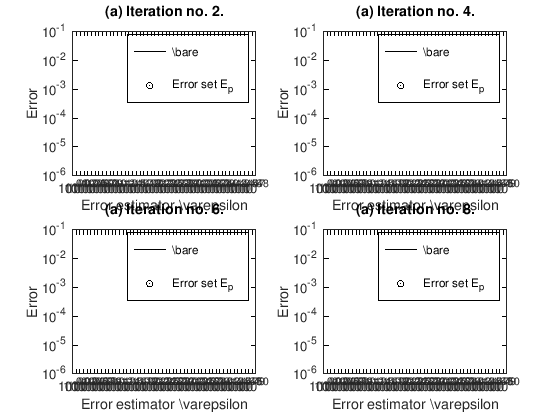

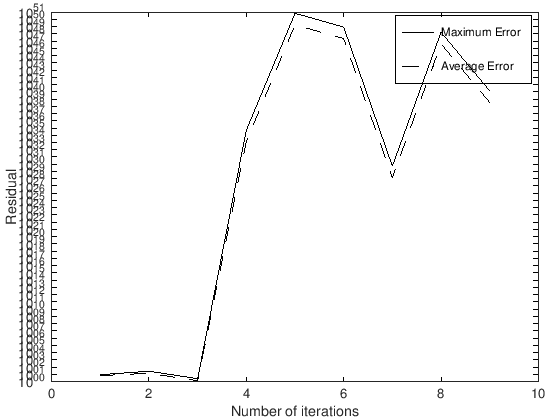

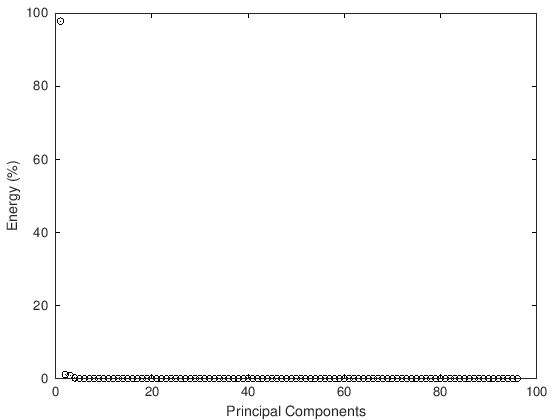

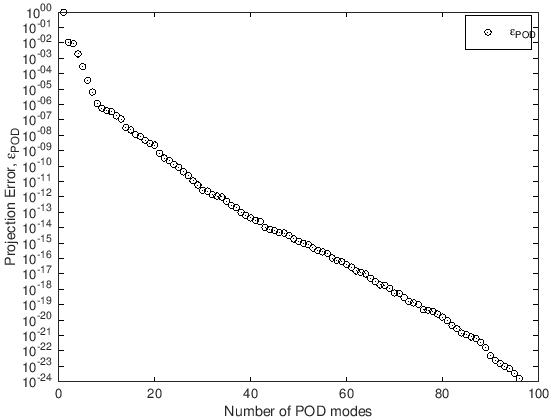

In [18]:
for kkk = 1:length(yy)
    RelativeError(1,kkk) = norm((BOND1{kkk} - BOND1r{kkk}),2)/norm(BOND1{kkk},2);
end

% Plot outputs
Niter=i;avrgError_AG=avrg_error;MaxError_AG=max_Error;
S=S1;REapprox=RE_appx;REU=RE_U;resdU=resd_U;

% Smooth function
smooth = @(x) movmean(x,5);

%% Maximum and average error estimator values plot
I = 1:Niter-1;
figure;
semilogy(I,MaxError_AG,'k','LineWidth',1.5)
hold on
semilogy(I,avrgError_AG,'k--','LineWidth',1.5)
legend({'Maximum Error','Average Error'},'Location','NorthEast')
xlabel('Number of iterations');
ylabel('Residual');

figure;
S2 = diag(S).^2;
sumS2 = sum(S2);
plot((S2/sumS2)*100,'ko','Linewidth',2); %Plot of singular values per mode
xlabel('Principal Components')
ylabel('Energy (%)')

figure;
semilogy(S2/sum(S2),'ko','Linewidth',2); %logarithmic plot of singular values
legend({'\epsilon_{POD}'},'Location','NorthEast')
xlabel('Number of POD modes');
ylabel('Projection Error, \epsilon_{POD}');

figure;
subplot(2,2,1)
loglog(smooth(REapprox(:,2:end)),smooth(MaxError_AG),'k','LineWidth',1.5)
hold on
loglog(REU(:,1:4),resdU(:,1:4),'ko')
ylim([1e-6 1e-1]);
legend({'\bar{e}','Error set E_p'},'Location','NorthEast')
xlabel('Error estimator \varepsilon');
ylabel('Error');
title('(a) Iteration no. 2.');

subplot(2,2,2)
loglog(smooth(REapprox(:,2:end)),smooth(MaxError_AG),'k','LineWidth',1.5)
hold on
loglog(REU(:,1:8),resdU(:,1:8),'ko')
ylim([1e-6 1e-1]);
legend({'\bar{e}','Error set E_p'},'Location','NorthEast')
xlabel('Error estimator \varepsilon');
ylabel('Error');
title('(a) Iteration no. 4.');

subplot(2,2,3)
loglog(smooth(REapprox(:,2:end)),smooth(MaxError_AG),'k','LineWidth',1.5)
hold on
loglog(REU(:,1:12),resdU(:,1:12),'ko')
ylim([1e-6 1e-1]);
legend({'\bar{e}','Error set E_p'},'Location','NorthEast')
xlabel('Error estimator \varepsilon');
ylabel('Error');
title('(a) Iteration no. 6.');

subplot(2,2,4)
loglog(smooth(REapprox(:,2:end)),smooth(MaxError_AG),'k','LineWidth',1.5)
hold on
loglog(REU(:,1:end),resdU(:,1:end),'ko')
ylim([1e-6 1e-1]);
legend({'\bar{e}','Error set E_p'},'Location','NorthEast')
xlabel('Error estimator \varepsilon');
ylabel('Error');
title('(a) Iteration no. 8.');